# Sequential High Dimensional Memory 

- Setting up the environment

## Autoencoder for Dimensionality Reduction 

- reducing the image from 4941 dimensions to 96
- setting up the encoder and decoder: 

In [36]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

# Encoding and Decoding the Autoencoder 
def encode(layer_sizes, data, encoders, biases):
    pl = data
    encoder_weights = encoders

    for i, ls in enumerate(layer_sizes[1:]):
        w = weights[i,:,:]
        b = biases[i,:]
        pl = tf.sigmoid(tf.matmul(pl, w) + b)

    return pl

def decode(layer_sizes, data, encoders, biases):
    pl = data
    encoder_weights = encoders

    for w, b, ls in zip(reversed(encoder_weights), reversed(biases), reversed(layer_sizes[:-1])):

        # return np.array([0])
        b = tf.zeros([ls])
        pl = tf.sigmoid(tf.matmul(pl, tf.transpose(w)) + b)

    return pl

Loading up the trained model: 

In [37]:
plt.rcParams['image.cmap'] = 'gray'
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.65)
s = lfw_people.images.shape
print lfw_people.images[0].shape
data = np.reshape(lfw_people.images,(s[0], s[1]*s[2]))
data = data/255.

# Loading trained model from pickl file
ae_load = pickle.load( open( "autoencoder/ae.p", "rb" ) )
layers = ae_load['layers']
weights = np.array(ae_load['weights'])
enc_biases = np.array(ae_load['enc_biases'])
dec_biases = np.array(ae_load['dec_biases'])

tf.reset_default_graph()
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

ids = [10, 87, 301, 421, 551, 602, 740, 105, 655]
num_ids = len(ids)

encoded = []
decoded = []
encoded_input = []
for i in range(num_ids):
    encoded.append(encode(layers, data[ids[i]][None,:], weights, enc_biases))
    decoded.append(decode(layers, encoded[i], weights, dec_biases))
    encoded_input.append(np.array(sess.run(encoded[i]))[0])

enc_vector_length = encoded_input[0].shape[0]
# print enc_vector_length

(81, 61)


## Cues and Inputs

Building up the cues and inputs to contain positional information for binding:

In [38]:
import nengo
from nengo import spa

def image_input(t):
    if t < 0.15:
        return encoded_input[0]
    elif t < 0.3:
        return encoded_input[1]
    elif t < 0.45:
        return encoded_input[2]
    elif t < 0.6:
        return encoded_input[3]
    elif t < 0.75:
        return encoded_input[4]
    elif t < 0.9:
        return encoded_input[5]
    elif t < 1.05:
        return encoded_input[6]
    elif t < 1.2:
        return encoded_input[7]
    elif t < 1.35:
        return encoded_input[8]
    else:
        return '0'

def position_input(t):
    if t < 0.15:
        return 'POS1'
    elif t < 0.3:
        return 'POS2'
    elif t < 0.45:
        return 'POS3'
    elif t < 0.6:
        return 'POS4'
    elif t < 0.75:
        return 'POS5'
    elif t < 0.9:
        return 'POS6'
    elif t < 1.05:
        return 'POS7'
    elif t < 1.2:
        return 'POS8'
    elif t < 1.35:
        return 'POS9'
    else:
        return '0'

def cue_input(t):
    if t < 1.35:
        return '0'
    sequence = ['0', 'POS1', '0','POS2','0', 'POS3', '0','POS4','0', 'POS5',
                '0','POS6','0', 'POS7', '0','POS8','0', 'POS9']
    idx = int(((t - 1.35) // (1.9 / len(sequence))) % len(sequence))
    return sequence[idx]

## Model Construction

Next, we will build our model and simulate it:

In [39]:
# Number of dimensions for the Semantic Pointers
dimensions = enc_vector_length
neurons = 100
model = spa.SPA(label="ImageRec")

with model:
    model.image_in = spa.Buffer(dimensions=dimensions)
    model.position_in = spa.Buffer(dimensions=dimensions)
    model.conv = spa.Memory(dimensions=dimensions, subdimensions=6, 
                            synapse=0.4, neurons_per_dimension=neurons) #, tau=-0.2)
    model.cue = spa.Buffer(dimensions=dimensions)
    model.out = spa.Buffer(dimensions=dimensions)
    
    # Connect the buffers
    cortical_actions = spa.Actions(
        'conv = image_in * position_in',
        'out = conv * ~cue'
    )
    model.cortical = spa.Cortical(cortical_actions)
    model.inp = spa.Input(position_in=position_input, cue=cue_input)
    
    image_in_buffer = nengo.Node(image_input)
    nengo.Connection(image_in_buffer, model.image_in.state.input)

    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    image_in = nengo.Probe(model.image_in.state.output)
    position_in = nengo.Probe(model.position_in.state.output)
    cue = nengo.Probe(model.cue.state.output)
    conv = nengo.Probe(model.conv.state.output)
    out = nengo.Probe(model.out.state.output)

    print "Building Simulation"
    sim = nengo.Simulator(model)
    print "Starting Simulation"
    sim.run(3.3)

Building Simulation
Building finished in 0:00:14.                                                   
Starting Simulation
Simulating finished in 0:03:05.                                                 


# Visualization

Visualize the results:

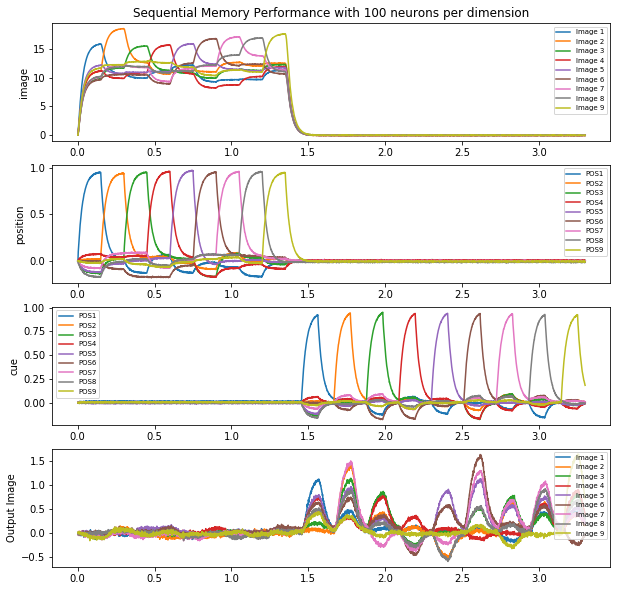

In [40]:
    plt.figure(figsize=(10, 10))
    vocab = model.get_default_vocab(dimensions)

    plt.subplot(4, 1, 1)
    for i, pointer in enumerate(encoded_input):
        plt.plot(sim.trange(), spa.similarity(sim.data[image_in], pointer))
    plt.legend(['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7', 'Image 8', 'Image 9'], fontsize='x-small')
    plt.ylabel("image")
    plt.title('Sequential Memory Performance with {} neurons per dimension'.format(neurons))
    
    plt.subplot(4, 1, 2)
    plt.plot(sim.trange(), model.similarity(sim.data, position_in))
    plt.legend(model.get_output_vocab('position_in').keys, fontsize='x-small')
    plt.ylabel("position")

    plt.subplot(4, 1, 3)
    plt.plot(sim.trange(), model.similarity(sim.data, cue))
    plt.legend(model.get_output_vocab('cue').keys, fontsize='x-small')
    plt.ylabel("cue")

    plt.subplot(4, 1, 4)
    for i, pointer in enumerate(encoded_input):
        plt.plot(sim.trange(), spa.similarity(sim.data[out], pointer) )
    plt.legend(['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7', 'Image 8', 'Image 9'], fontsize='x-small')
    plt.ylabel("Output Image")

    plt.show()

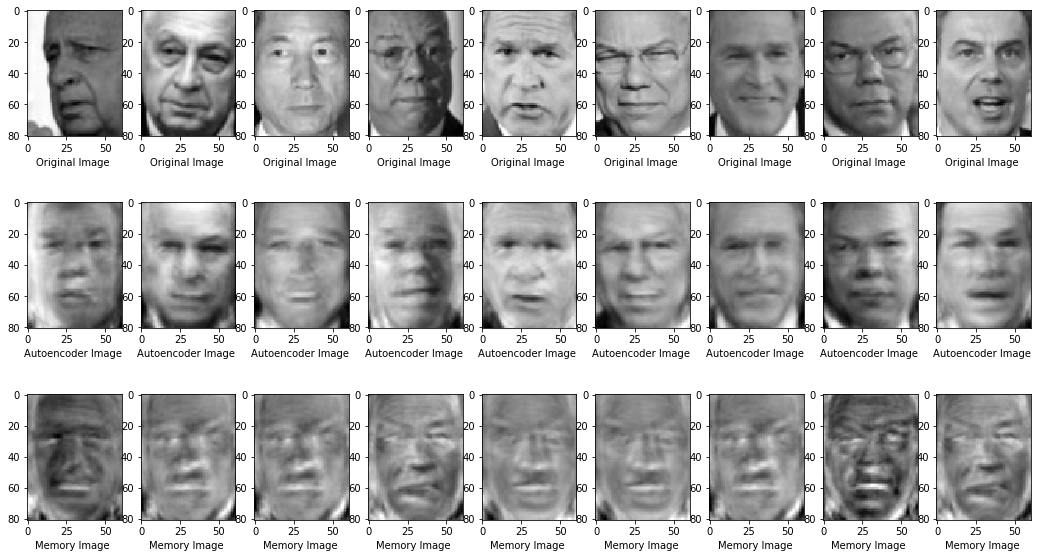

In [41]:
    mem_decoded = []
    for i in range(num_ids):
        image_sim = spa.similarity(sim.data[out], encoded_input[i])[:,0]
        image_mem_ind = np.where(image_sim == np.max(image_sim))[0] 
        mem_extract = tf.cast(sim.data[out][image_mem_ind,:], tf.float32)
        mem_decoded.append(decode(layers, mem_extract, weights, dec_biases))
    
    plt.figure(figsize=(18, 10))
    plt.title('Visual Performance with {} neurons per dimension'.format(neurons))
    
    for i in range(len(ids)*3):
        im_ind = i+1
        plt.subplot(3,num_ids,im_ind)
        
        if i < num_ids:
            plt.imshow(data[ids[i]].reshape(s[1], s[2]))
            plt.xlabel('Original Image ')# + str(im_ind%num_ids))
        elif i < num_ids*2:
            plt.imshow(sess.run(decoded[i-num_ids]).reshape(s[1], s[2]))
            plt.xlabel('Autoencoder Image ')# + str(im_ind%num_ids))
        elif i < num_ids*3:
            plt.imshow(sess.run(mem_decoded[i-num_ids*2]).reshape(s[1], s[2]))
            plt.xlabel('Memory Image ')# + str(im_ind%num_ids))
   
    plt.show()


### Observe Recency 
- Image to the right most (most recently input) is the closest to the input image
- Previous images have noise leaking in from most recent images 

## Evaluation Metrics 

RMSE Calculations

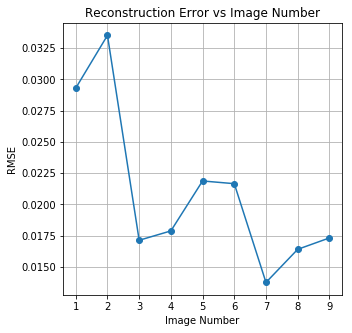

In [43]:
    # RMSE
    mem_rmse = []
    ae_rmse = []
    for i in range(num_ids):
        mem_rmse.append(np.average((data[ids[i]] - sess.run(mem_decoded[i]))**2))
        ae_rmse.append(np.average((data[ids[i]] - sess.run(decoded[i]))**2))
    plt.figure(figsize=(5, 5))
    plt.plot(range(1,num_ids+1), np.array(mem_rmse) - np.array(ae_rmse), marker='o')
    plt.xlabel('Image Number')
    plt.ylabel('RMSE')
    plt.title('Reconstruction Error vs Image Number')
    plt.grid()
    plt.show()
    